# PCA Challenge Solutions: Predict Machine Failure

The task is to predict the condition of a motor based on the features provided.

This is ultimately a supervised learning task, but we will add PCA to our pre-processing step.

The goal here is to get the highest overall accuracy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Data/motor-data.csv')
df.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,...,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column48,Column49
0,-3.014600e-07,8.260300e-06,-0.000012,-0.000002,-1.438600e-06,-0.000021,0.031718,0.031710,0.031721,-0.032963,...,-0.63308,2.9646,8.1198,-1.4961,-1.4961,-1.4961,-1.4996,-1.4996,-1.4996,1
1,2.913200e-06,-5.247700e-06,0.000003,-0.000006,2.778900e-06,-0.000004,0.030804,0.030810,0.030806,-0.033520,...,-0.59314,7.6252,6.1690,-1.4967,-1.4967,-1.4967,-1.5005,-1.5005,-1.5005,1
2,-2.951700e-06,-3.184000e-06,-0.000016,-0.000001,-1.575300e-06,0.000017,0.032877,0.032880,0.032896,-0.029834,...,-0.63252,2.7784,5.3017,-1.4983,-1.4983,-1.4982,-1.4985,-1.4985,-1.4985,1
3,-1.322600e-06,8.820100e-06,-0.000016,-0.000005,-7.282900e-07,0.000004,0.029410,0.029401,0.029417,-0.030156,...,-0.62289,6.5534,6.2606,-1.4963,-1.4963,-1.4963,-1.4975,-1.4975,-1.4976,1
4,-6.836600e-08,5.666300e-07,-0.000026,-0.000006,-7.940600e-07,0.000013,0.030119,0.030119,0.030145,-0.031393,...,-0.63010,4.5155,9.5231,-1.4958,-1.4958,-1.4958,-1.4959,-1.4959,-1.4959,1


In [3]:
# There are no null values and all of the features are floats. The last column is the target and is an integer (This is a classification task)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58509 entries, 0 to 58508
Data columns (total 49 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Column1   58509 non-null  float64
 1   Column2   58509 non-null  float64
 2   Column3   58509 non-null  float64
 3   Column4   58509 non-null  float64
 4   Column5   58509 non-null  float64
 5   Column6   58509 non-null  float64
 6   Column7   58509 non-null  float64
 7   Column8   58509 non-null  float64
 8   Column9   58509 non-null  float64
 9   Column10  58509 non-null  float64
 10  Column11  58509 non-null  float64
 11  Column12  58509 non-null  float64
 12  Column13  58509 non-null  float64
 13  Column14  58509 non-null  float64
 14  Column15  58509 non-null  float64
 15  Column16  58509 non-null  float64
 16  Column17  58509 non-null  float64
 17  Column18  58509 non-null  float64
 18  Column19  58509 non-null  float64
 19  Column20  58509 non-null  float64
 20  Column21  58509 non-null  fl

In [4]:
# Explore the target column.  We see this is balanced and there are 11 possible classes.  This is a multiclass classification task.
df['Column49'].value_counts()

1     5319
2     5319
3     5319
4     5319
5     5319
6     5319
7     5319
8     5319
9     5319
10    5319
11    5319
Name: Column49, dtype: int64

In [5]:
# Identify the target and features
y = df['Column49']
X = df.drop(columns = 'Column49')

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [7]:
# Do a quick look at the stats. Keep in mind that outliers may be indicators of defects
X_train.describe()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,...,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column48
count,43881.000000,4.388100e+04,4.388100e+04,43881.000000,4.388100e+04,4.388100e+04,43881.000000,43881.000000,43881.000000,43881.000000,...,43881.000000,43881.000000,43881.000000,43881.000000,43881.000000,43881.000000,43881.000000,43881.000000,43881.00000,43881.000000
mean,-0.000003,1.584325e-06,1.339556e-06,-0.000001,1.241655e-06,9.622144e-07,0.001933,0.001931,0.001930,-0.011914,...,8.413442,-0.341709,7.331173,8.282580,-1.500890,-1.500915,-1.500808,-1.497758,-1.49778,-1.497673
std,0.000083,5.866064e-05,2.385364e-04,0.000072,6.118783e-05,2.291861e-04,0.036434,0.036431,0.036435,0.066602,...,6.932460,28.649588,12.722574,6.602679,0.003662,0.003672,0.003636,0.003190,0.00319,0.003202
min,-0.013721,-5.414400e-03,-1.358000e-02,-0.012787,-8.355900e-03,-9.741300e-03,-0.139890,-0.135940,-0.130860,-0.218640,...,0.522180,-0.889130,-0.596830,0.513630,-1.522400,-1.522500,-1.522400,-1.521400,-1.52320,-1.521300
25%,-0.000007,-1.432400e-05,-7.226200e-05,-0.000005,-1.477400e-05,-7.302800e-05,-0.019937,-0.019954,-0.019921,-0.032067,...,4.440000,-0.715340,1.453600,4.432100,-1.503300,-1.503400,-1.503200,-1.499600,-1.49960,-1.499500
50%,-0.000003,9.125000e-07,5.447700e-07,-0.000001,7.315900e-07,2.565900e-07,0.013195,0.013203,0.013229,-0.015513,...,6.577000,-0.661320,3.316000,6.470300,-1.500300,-1.500300,-1.500300,-1.498100,-1.49810,-1.498000
75%,0.000002,1.875900e-05,7.494700e-05,0.000004,1.913300e-05,7.266100e-05,0.024776,0.024777,0.024787,0.020614,...,9.949700,-0.574050,8.333300,9.874600,-1.498200,-1.498200,-1.498200,-1.496200,-1.49620,-1.496100
max,0.005784,4.525300e-03,5.237700e-03,0.001453,8.245100e-04,2.753600e-03,0.069125,0.069130,0.069131,0.352580,...,265.330000,3670.800000,889.930000,153.150000,-1.457600,-1.456100,-1.455500,-1.337200,-1.33720,-1.337100


In [8]:
# We must scale the data for use in PCA
scaler = StandardScaler()

# We are asking for the number of Principal Components that will retain 95% of the variance in the original features
pca = PCA(n_components = .95)

# Preprocessing Pipeline, so we can reuse it for other model types:
# We have only numeric data, so there is no need for a column transformer.
# We can perform the same processing steps on all columns.
pca_processing = make_pipeline(scaler, pca)

print('Shape before PCA:', X_train.shape)
print('Shape after PCA:', pca_processing.fit_transform(X_train).shape)
print('Column count reduced by: ', X_train.shape[1] - pca_processing.fit_transform(X_train).shape[1])

Shape before PCA: (43881, 48)
Shape after PCA: (43881, 20)
Column count reduced by:  28


We were able to reduce 48 columns to only 16 while retaining 90% of the information (variance) of the original features.

In [9]:
def eval_classification(model, X_train, X_test, y_train, y_test):
  print('Train Report:', classification_report(y_train, model.predict(X_train)))
  print('Test Report:', classification_report(y_test, model.predict(X_test)))

  cm = confusion_matrix(y_test, model.predict(X_test))

  plt.figure(figsize=(15, 15))
  heatmap(cm, annot=True)
  plt.xlabel('Predicted', fontsize=40)
  plt.ylabel('True', fontsize=40)
  plt.show()

# Without PCA

In [10]:
%%time
# Without PCA
knn = KNeighborsClassifier()

# Now we will build the pipeline
knn_pipe = make_pipeline(scaler, knn)
knn_pipe.fit(X_train, y_train)


CPU times: total: 125 ms
Wall time: 46 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

One interesting thing about KNN is how quikcly it fits and how slowly it predicts.  All the work is done at predict time, which makes it different than many other models.

Train Report:               precision    recall  f1-score   support

           1       0.84      0.89      0.86      3990
           2       0.86      0.89      0.88      3989
           3       0.89      0.94      0.91      3989
           4       0.90      0.94      0.92      3989
           5       0.84      0.83      0.83      3989
           6       0.82      0.83      0.82      3990
           7       1.00      0.99      1.00      3989
           8       0.92      0.84      0.88      3989
           9       0.94      0.88      0.91      3989
          10       0.90      0.86      0.88      3989
          11       1.00      1.00      1.00      3989

    accuracy                           0.90     43881
   macro avg       0.90      0.90      0.90     43881
weighted avg       0.90      0.90      0.90     43881

Test Report:               precision    recall  f1-score   support

           1       0.73      0.80      0.76      1329
           2       0.78      0.79      0.79      13

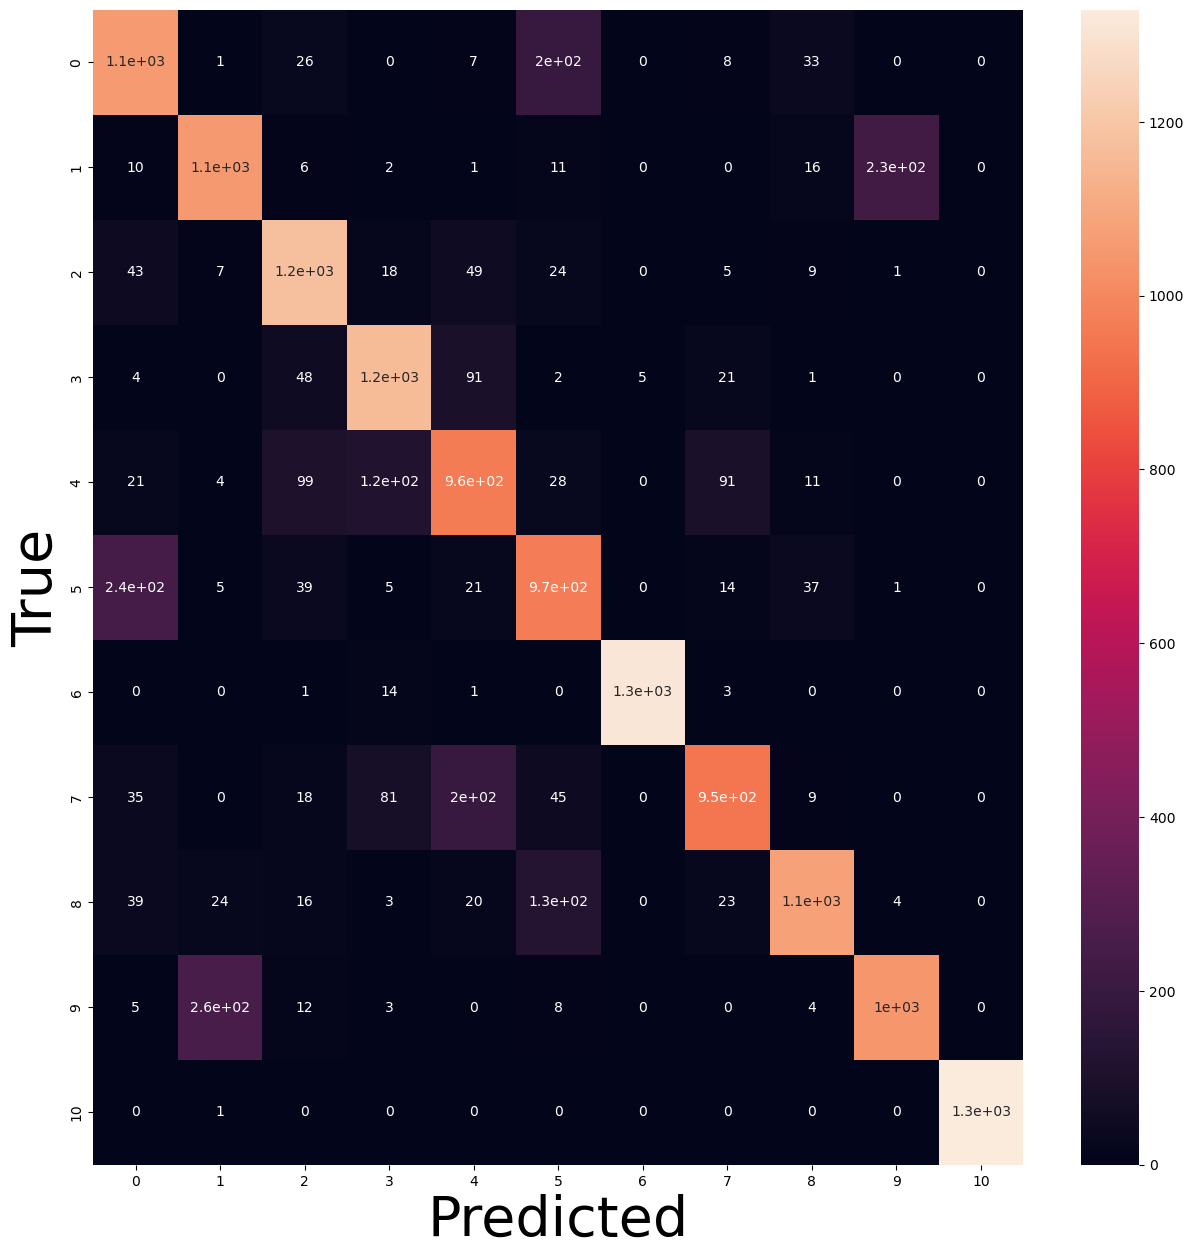

CPU times: total: 33 s
Wall time: 5.11 s


In [11]:
%%time
# evaluate the pipeline
eval_classification(knn_pipe, X_train, X_test, y_train, y_test)

# With PCA

In [12]:
%%time
# Now we will build the pipeline
knn_pca_pipe = make_pipeline(scaler, pca, knn)

# fit the pipeline
knn_pca_pipe.fit(X_train, y_train)

CPU times: total: 250 ms
Wall time: 93.3 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

Train Report:               precision    recall  f1-score   support

           1       0.85      0.89      0.87      3990
           2       0.87      0.90      0.88      3989
           3       0.90      0.94      0.92      3989
           4       0.91      0.94      0.92      3989
           5       0.85      0.84      0.84      3989
           6       0.82      0.85      0.83      3990
           7       1.00      0.99      1.00      3989
           8       0.93      0.85      0.89      3989
           9       0.94      0.88      0.91      3989
          10       0.91      0.87      0.89      3989
          11       1.00      1.00      1.00      3989

    accuracy                           0.91     43881
   macro avg       0.91      0.91      0.91     43881
weighted avg       0.91      0.91      0.91     43881

Test Report:               precision    recall  f1-score   support

           1       0.74      0.80      0.77      1329
           2       0.78      0.80      0.79      13

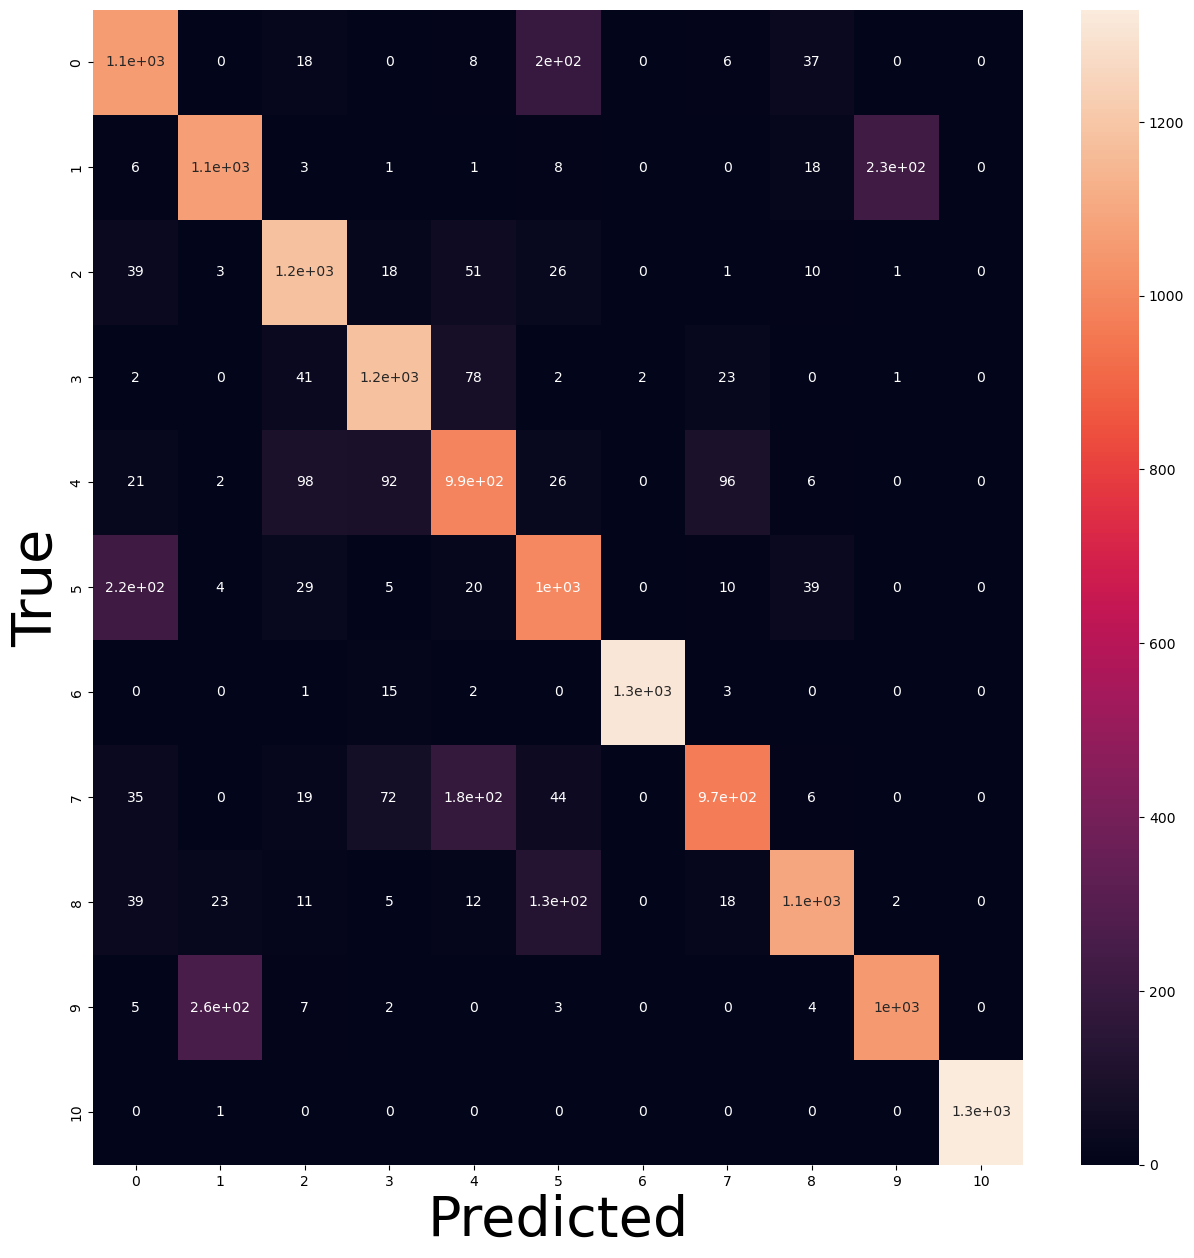

CPU times: total: 27.3 s
Wall time: 4.52 s


In [13]:
%%time
# evaluate the pipeline

eval_classification(knn_pca_pipe, X_train, X_test, y_train, y_test)

# This is just a default model, but we could try a gridsearch or other classifier algorithms to reduce overfitting and see if we could get a better result!

In [14]:
knn = KNeighborsClassifier()

knn_pca_pipe = make_pipeline(StandardScaler(), PCA(), knn)
knn_pca_pipe.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('pca', PCA()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'pca': PCA(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [15]:
knn_grid = {'pca__n_components':[.5, .7, .9, None],
            'kneighborsclassifier__n_neighbors':[1, 5, 10, 20]}

knn_grid = GridSearchCV(knn_pca_pipe, param_grid=knn_grid, cv=3)

Train Report:               precision    recall  f1-score   support

           1       0.80      0.86      0.83      3990
           2       0.91      0.93      0.92      3989
           3       0.91      0.90      0.90      3989
           4       0.85      0.88      0.86      3989
           5       0.87      0.87      0.87      3989
           6       0.88      0.86      0.87      3990
           7       1.00      1.00      1.00      3989
           8       0.90      0.85      0.87      3989
           9       0.93      0.94      0.94      3989
          10       0.94      0.89      0.91      3989
          11       1.00      1.00      1.00      3989

    accuracy                           0.91     43881
   macro avg       0.91      0.91      0.91     43881
weighted avg       0.91      0.91      0.91     43881

Test Report:               precision    recall  f1-score   support

           1       0.71      0.76      0.73      1329
           2       0.87      0.90      0.89      13

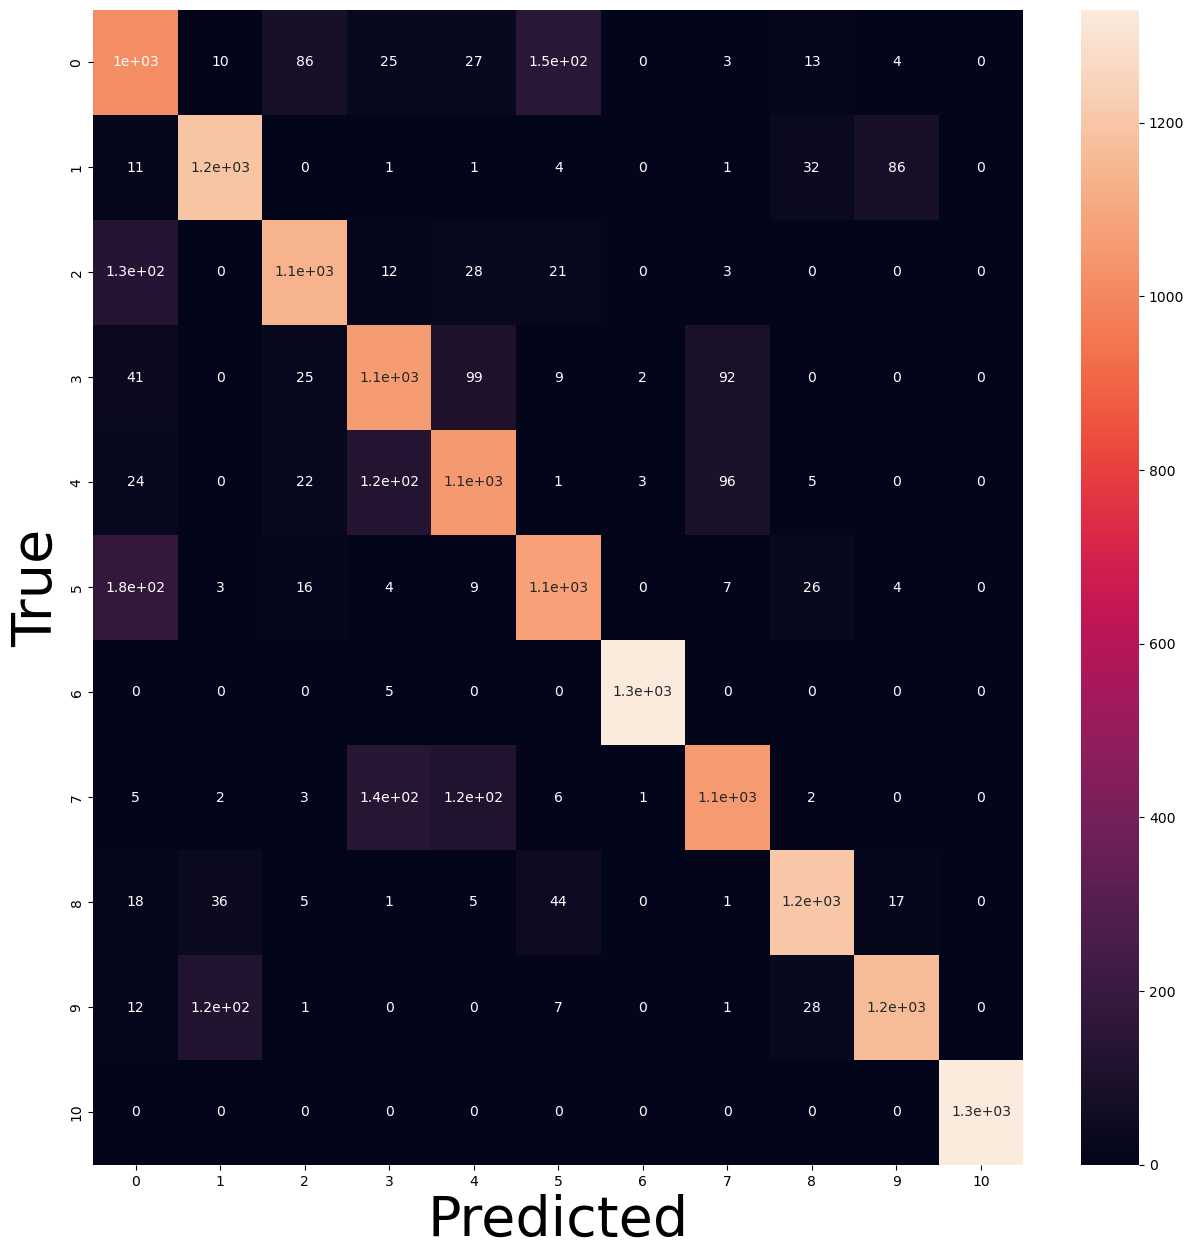

CPU times: total: 2min 51s
Wall time: 44.1 s


In [16]:
%%time
knn_grid.fit(X_train, y_train)

eval_classification(knn_grid, X_train, X_test, y_train, y_test)

We can see that PCA, speeds up the computation little bit